# Mouse CNS Spatial Reference Mapping Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 10.02.2024

In this tutorial we apply NicheCompass to integrate three samples (sagittal brain sections) of the STARmap PLUS mouse central nervous system dataset / atlas from [Shi, H. et al. Spatial atlas of the mouse central nervous system at molecular resolution. Nature 622, 552–561 (2023)](https://www.nature.com/articles/s41586-023-06569-5) in a spatial reference mapping setting (i.e. the model is first trained on the reference samples, and the query sample is then mapped onto the pretrained reference model by fine-tuning). The first two samples are used as reference samples and the third sample is the query.

Sample 1 (reference) has:
- 91,246 observations at cellular resolution with cell type annotations
- 1022 probed genes

Sample 2 (reference) has:
- 123,836 observations at cellular resolution with cell type annotations
- 1022 probed genes

Sample 3 (query) has:
- 207,591 observations at cellular resolution with cell type annotations
- 1022 probed genes

- Check the [documentation](https://nichecompass.readthedocs.io/en/latest/installation.html) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1l9W0MDVZ451k1L7s6GGH4ONH4tEK4EKj). It has to be stored under ```<repository_root>/data/spatial_omics/```.
    - starmap_plus_mouse_cns_batch1.h5ad (reference sample 1)
    - starmap_plus_mouse_cns_batch2.h5ad (reference sample 2)
    - starmap_plus_mouse_cns_batch3.h5ad (query sample 1)
- A pretrained model to run only the analysis can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1z2DQHV9hG22B5OSWox8U3usf_8LKZGGH). It has to be stored under ```<repository_root>/artifacts/spatial_reference_mapping/<timestamp>/model/```.
  - 07022024_091846

## 1. Setup

### 1.1 Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

### 1.2 Define Parameters

In [5]:
### Dataset ###
dataset = "starmap_plus_mouse_cns"
species = "mouse"
reference_batches = ["batch1", "batch2"]
query_batches = ["batch3"]
spatial_key = "spatial"
n_neighbors = 4
mapping_entity_key = "mapping_entity"

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
cat_covariates_keys = ["batch"]
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
cat_covariates_embeds_injection = ["gene_expr_decoder"]
cat_covariates_embeds_nums = [3]
cat_covariates_no_edges = [True]
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
latent_leiden_resolution = 0.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [6]:
warnings.filterwarnings("ignore")

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [8]:
# Define paths
ga_data_folder_path = "../../../data/gene_annotations"
gp_data_folder_path = "../../../data/gene_programs"
so_data_folder_path = "../../../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../../artifacts"
model_folder_path = f"{artifacts_folder_path}/spatial_reference_mapping/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/spatial_reference_mapping/{current_timestamp}/figures"

### 1.5 Create Directories

In [11]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Reference Model Preparation

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders). 
- The user can provide a custom GP mask to NicheCompass based on the biological question of interest.
- As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - NicheNet (Combined Interaction GPs)

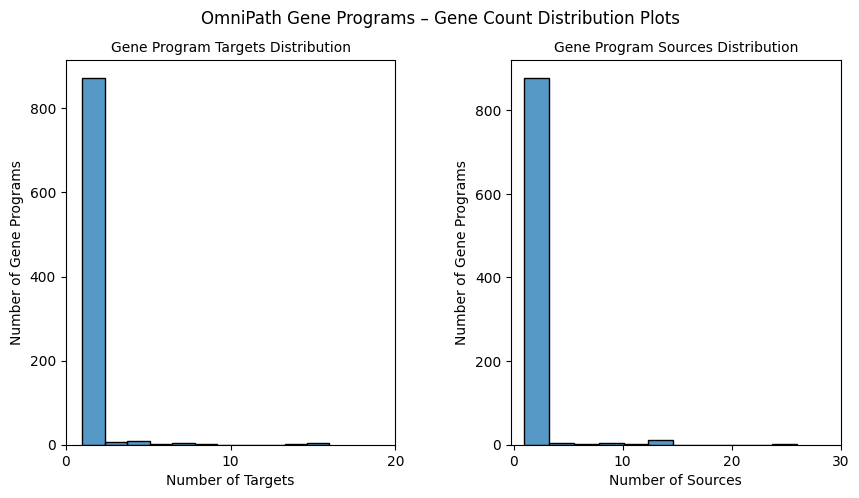

In [12]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [13]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

FBLN2_ligand_receptor_GP: {'sources': ['Fbln2'], 'targets': ['Itgb3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


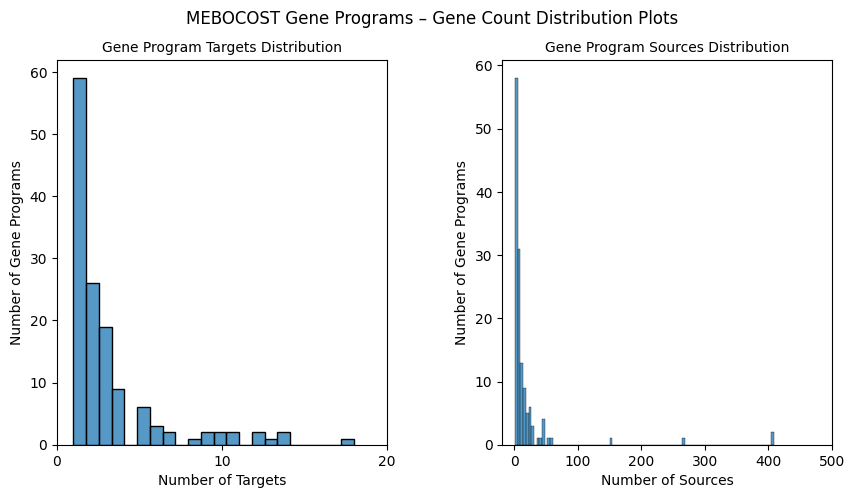

In [14]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [15]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

L-Cysteine_metabolite_enzyme_sensor_GP: {'sources': ['Anpep', 'Cars2', 'Cbs', 'Cdo1', 'Cth', 'Gclc', 'Ggct', 'Got1', 'Got2', 'Lap3', 'Mocos', 'Nfs1', 'Pcyox1', 'Ppcs'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc43a2', 'Slc7a11'], 'targets_categories': ['sensor', 'sensor']}


In [ ]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [ ]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

In [ ]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [ ]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

### 2.2 Load Reference Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the biological question of interest.
- In the spatial reference mapping setting, we will compute a separate spatial adjacency matrix for each sample in the reference and query, respectively, and combine them as two disconnected components, one for the reference and one for the query. Here, we build the dataset used for reference model training.

In [ ]:
adata_batch_list = []
print("Processing reference batches...")
for batch in reference_batches:
    print(f"Processing batch {batch}...")
    print("Loading data...")
    adata_batch = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_{batch}.h5ad")

    print("Computing spatial neighborhood graph...\n")
    # Compute (separate) spatial neighborhood graphs
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata_reference = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_reference.obsp[adj_key] = sp.vstack(batch_connectivities)

adata_reference.obs[mapping_entity_key] = "reference"

### 2.3 Add GP Mask to Reference Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.5 Explore Data

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata_reference,
    cat_key=cell_type_key)

In [ ]:
samples_reference = adata_reference.obs[sample_key].unique().tolist()

In [ ]:
for sample in samples_reference:
    adata_batch = adata_reference[adata_reference.obs[sample_key] == sample]
    
    print(f"Summary of sample {sample}:")
    print(f"Number of nodes (observations): {adata_batch.layers[counts_key].shape[0]}")
    print(f"Number of node features (genes): {adata_batch.layers[counts_key].shape[1]}")

    # Visualize cell-level annotated data in physical space
    sc.pl.spatial(adata_batch,
                  color=cell_type_key,
                  palette=cell_type_colors,
                  spot_size=spot_size)

## 3. Reference Model Training

### 3.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     cat_covariates_embeds_injection=cat_covariates_embeds_injection,
                     cat_covariates_keys=cat_covariates_keys,
                     cat_covariates_no_edges=cat_covariates_no_edges,
                     cat_covariates_embeds_nums=cat_covariates_embeds_nums,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=f"{model_folder_path}/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Query Mapping Preparation

### 4.1 Load Query Data & Compute Spatial Neighbor Graph

Now we will load the query samples to fine-tune the reference model.

In [ ]:
adata_batch_list = []
print("Processing query batches...")
for batch in query_batches:
    print(f"Processing batch {batch}...")
    print("Loading data...")
    adata_batch = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_{batch}.h5ad")

    print("Computing spatial neighborhood graph...\n")
    # Compute (separate) spatial neighborhood graphs
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata_query = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_query.obsp[adj_key] = sp.vstack(batch_connectivities)

adata_query.obs[mapping_entity_key] = "query"

### 4.2 Add GP Mask to Query Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata_query,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 4.4 Explore Data

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata_query,
    cat_key=cell_type_key)

In [ ]:
samples_query = adata_query.obs[sample_key].unique().tolist()

In [ ]:
for sample in samples_query:
    adata_batch = adata_query[adata_query.obs[sample_key] == sample]
    
    print(f"Summary of sample {sample}:")
    print(f"Number of nodes (observations): {adata_batch.layers[counts_key].shape[0]}")
    print(f"Number of node features (genes): {adata_batch.layers[counts_key].shape[1]}")

    # Visualize cell-level annotated data in physical space
    sc.pl.spatial(adata_batch,
                  color=cell_type_key,
                  palette=cell_type_colors,
                  spot_size=spot_size)

## 5. Map Query on Reference Model

### 5.1 Initialize, Train & Save Model

Load model trained on reference data for transfer learning with query data. Freeze all weights except for covariate embedding weights.

In [ ]:
load_timestamp = "26062023_162429"

model_folder_path = f"{artifacts_folder_path}/spatial_reference_mapping/{load_timestamp}/model"

In [ ]:
# Loading reference model with query data
print("Retrieving reference model...")
model = NicheCompass.load(
    dir_path=f"{model_folder_path}/reference",
    adata=adata_query,
    adata_file_name="adata.h5ad",
    gp_names_key=gp_names_key,
    unfreeze_all_weights=False,
    unfreeze_cat_covariates_embedder_weights=True)

In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available)

In [ ]:
# Save trained model
model.save(dir_path=f"{model_folder_path}/query",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

### 5.2 Integrate Reference & Query Data

Now that we have fine-tuned the reference model with the query data, we will load it with the integrated reference and query data.

In [ ]:
# Integrate reference and query data
adata_batch_list = [adata_reference, adata_query]
adata_reference_query = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_reference_query.obsp[adj_key] = sp.vstack(batch_connectivities)

### 5.3 Add GP Mask to Integrated Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata_reference_query,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 5.4 Load Fine-tuned Model with Reference & Query Data

In [ ]:
# Load query model with the integrated data
print("Retrieving query model...")
model = NicheCompass.load(
    dir_path=f"{model_folder_path}/query",
    adata=adata_reference_query,
    adata_file_name="adata.h5ad",
    gp_names_key=gp_names_key)

In [ ]:
print("Computing reference query latent GP space...")
model.adata.obsm[latent_key], _ = model.get_latent_representation(
   adata=model.adata,
   counts_key=counts_key,
   adj_key=adj_key,
   cat_covariates_keys=cat_covariates_keys,
   only_active_gps=True,
   return_mu_std=True,
   node_batch_size=model.node_batch_size_)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save model
model.save(dir_path=f"{model_folder_path}/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 6. Analysis

In [ ]:
load_timestamp = "26062023_162429"

figure_folder_path = f"{artifacts_folder_path}/spatial_reference_mapping/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/spatial_reference_mapping/{load_timestamp}/model" \
                     "/reference_query"

os.makedirs(figure_folder_path, exist_ok=True)

In [ ]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

In [ ]:
samples = model.adata.obs[sample_key].unique().tolist()

### 6.1 Visualize NicheCompass Latent GP Space

First, we will check how well the NicheCompass latent GP features are integrated across reference and query.

In [ ]:
mapping_entity_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=mapping_entity_key)

In [ ]:
# Create plot of mapping entity annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Batches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[mapping_entity_key],
           groups=groups,
           palette=mapping_entity_colors,
           title=f"Batches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[mapping_entity_key],
                  groups=groups,
                  palette=mapping_entity_colors,
                  spot_size=spot_size,
                  title=f"Batches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

Next, we will check how well the NicheCompass latent GP features are integrated across different batches.

In [ ]:
batch_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=condition_key)

In [ ]:
# Create plot of batch annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Batches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cat_covariates_keys[0]],
           groups=groups,
           palette=batch_colors,
           title=f"Batches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cat_covariates_keys[0]],
                  groups=groups,
                  palette=batch_colors,
                  spot_size=spot_size,
                  title=f"Batches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

Next, let's look at the preservation of cell type annotations in the latent GP space. Note that the goal of NicheCompass is not a separation of cell types but rather to identify spatially consistent cell niches.

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 6.2 Identify Niches

We compute Leiden clustering based on the NicheCompass embeddings to identify spatial cellular niches.

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  spot_size=spot_size,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 6.3 Analyze Niches

Now we will analyze the identified spatial cellular niches.

#### 6.3.1 Niche Composition

We can analyze the niche composition in terms of cell type labels.

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Type Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 6.3.2 Cell Type Neighbor Importances

Now we will investigate neighbor importances in terms of cell type labels of different niches.

In [ ]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [ ]:
# Get cell type neighbor importances for each niche / latent cluster
niche_neighbor_importances_df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=cell_type_key,
    group_key=latent_cluster_key,
    agg_rows=True)

In [ ]:
display(niche_neighbor_importances_df)

In [ ]:
# Generate chord plots showing cell type neighbor importances
# for each niche / latent cluster
groups = ["0", "1", "2", "3", "4", "5"] # "all"
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_neighbor_importances.png"

create_cell_type_chord_plot_from_df(
        adata=model.adata,
        df=niche_neighbor_importances_df,
        link_threshold=0.01,
        cell_type_key=cell_type_key,
        group_key=latent_cluster_key,
        groups=groups,
        plot_label="Niche",
        save_fig=save_fig,
        file_path=file_path)

### 6.4 Perform Differential Gene Program Testing

Now we can test which communication gene programs are differentially expressed in a niche. To this end, we will perform differential gene program testing of a selected niche, e.g. latent cluster / niche "0" (```selected_cats = ["0"]```) vs all other latent clusters / niches (```comparison_cats = "rest"```). However, differential gene program testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential gene program testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["2", "3"]``` to perform differential gene program testing against latent clusters / niches "2" and "3" as opposed to against all other latent clusters / niches.

We choose a log bayes factor threshold of 2.3 to determine strongly enriched gene programs. Alternatively, the threshold could be set to a more restrictive value of 4.6 to only allow decisively enriched gene programs to be identified (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = ["0"]
comparison_cats = "rest"
title = f"NicheCompass Latent Cluster Strongly Enriched Gene Programs"
log_bayes_factor_thresh = 2.3 # 4.6
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_clusters_enriched_gps_dotplot.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Create dotplot of results
fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "latent_clusters_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 6.5 Analyze Enriched Gene Programs

Now we will have a look at the gene program scores as well as the (log normalized) count distributions of
the most important omics features of the differentially expressed gene programs.

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_0_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)